In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']
OBNC_algorithms = ['OBNC', 'OBNC-remove-sensitive', 
                   'OBNC-optimize-demographic-parity-0', 'OBNC-optimize-demographic-parity-0.5',
                   'OBNC-fair-0', 'OBNC-fair-0.5']

experiments = ['adult_sex_Male', 'adult_race_White', 'german_sex_Male', 
               'compas_sex', 'compas_race_Caucasian', 'ricci_Race_W', 
               'diabetes_race_Caucasian', 'titanic_sex']

datasets = ['adult', 'german', 'compas', 'ricci', 'diabetes', 'titanic']

attr = {
    'adult': ['sex_Male', 'race_White'],
    'german': ['sex_Male'],
    'compas': ['sex', 'race_Caucasian'],
    'ricci': ['Race_W'],
    'diabetes': ['race_Caucasian'],
    'titanic': ['sex']
}

colors = {
    'PL':'tab:blue', 
    'STC':'tab:orange', 
    'CC':'tab:green', 
    'HLNC':'tab:red', 
    'OBNC':'tab:purple', 
    'BE':'tab:brown',
    'OBNC-remove-sensitive': 'tab:pink',
    'OBNC-optimize-demographic-parity-0': 'tab:cyan',
    'OBNC-optimize-demographic-parity-0.5': 'darkcyan',
    'OBNC-fair-0': 'tab:gray',
    'OBNC-fair-0.5': 'dimgrey'
}

In [3]:
runs = {}
for exp in experiments:
    for alg in base_algorithms:
        runs[f'{exp}_{alg}'] = pd.read_csv(f'../fairness_benchmark_results/{exp}_{alg}.csv')
    for alg in OBNC_algorithms:
        runs[f'{exp}_{alg}'] = pd.read_csv(f'../fairness_benchmark_results/{exp}_{alg}.csv')

In [4]:
pred_metrics = ['accuracy_0.5', 'roc_auc']

fair_metrics = [
        #'auc_difference',
        'equal_opportunity_difference_0.5', 
        'predictive_equality_difference_0.5',
        'demographic_parity_difference_0.5',
        'equalized_odds_difference_0.5']

metrics = pred_metrics + fair_metrics

# Dataset characterization

In [5]:
dataset_stats = pd.DataFrame(columns=['dataset', 'sensitive attribute', 'instances', 'features', 'positive (%)', 'protected (%)', 'positive in protected group (%)', 'positive in unprotected group (%)'])

i = 0
for dataset in datasets:
    data = pd.read_csv(f'../data/{dataset}.csv')
    for attr_name in attr[dataset]:
        dataset_stats.loc[i] = [
            dataset,
            attr_name,
            data.shape[0],
            data.shape[1] - 1,
            "{:.0f} %".format((data[data['y'] == 1].shape[0]/data.shape[0])*100),
            "{:.0f} %".format((data[data[attr_name] == 1].shape[0]/data.shape[0])*100),
            "{:.0f} %".format((data[(data[attr_name] == 1) & (data['y'] == 1)].shape[0]/data[data[attr_name] == 1].shape[0])*100),
            "{:.0f} %".format((data[(data[attr_name] == 0) & (data['y'] == 1)].shape[0]/data[data[attr_name] == 0].shape[0])*100),
        ]
        i += 1

dataset_stats

,dataset,sensitive attribute,instances,features,positive (%),protected (%),positive in protected group (%),positive in unprotected group (%)
0,adult,sex_Male,45175,104,25 %,68 %,31 %,11 %
1,adult,race_White,45175,104,25 %,86 %,26 %,16 %
2,german,sex_Male,1000,58,70 %,69 %,72 %,65 %
3,compas,sex,4966,11,50 %,81 %,53 %,39 %
4,compas,race_Caucasian,4966,11,50 %,40 %,42 %,55 %
5,ricci,Race_W,118,7,47 %,58 %,60 %,30 %
6,diabetes,race_Caucasian,34071,48,33 %,75 %,34 %,32 %
7,titanic,sex,1309,11,38 %,64 %,19 %,73 %


In [6]:
run = runs['diabetes_race_Caucasian_CC']
run.loc[run['metrics.roc_auc'].isna()]['metrics.roc_auc']

0   NaN
1   NaN
2   NaN
Name: metrics.roc_auc, dtype: float64

# Performance

In [7]:
def trade_off(test_set, fair_metric, pred_metric, ax, algorithms):
    for alg in algorithms:
        fairness = []
        predictive = []
        for exp in experiments:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['tags.train_set'] == 'corrected') & (run['tags.test_set'] == test_set)]
            if pd.notna(run[f'metrics.{fair_metric}'].values[0]):
                fairness.append(run[f'metrics.{fair_metric}'].values[0])
            if pd.notna(run[f'metrics.{pred_metric}'].values[0]):
                predictive.append(run[f'metrics.{pred_metric}'].values[0])
        ax.scatter(np.mean(fairness), np.mean(predictive), label=alg, color=colors[alg])

    fairness = []
    predictive = []
    for exp in experiments:
        run = runs[f'{exp}_{algorithms[0]}']
        run = run.loc[(run['tags.train_set'] == 'noisy') & (run['tags.test_set'] == test_set)]
        if pd.notna(run[f'metrics.{fair_metric}'].values[0]):
            fairness.append(run[f'metrics.{fair_metric}'].values[0])
        if pd.notna(run[f'metrics.{pred_metric}'].values[0]):
            predictive.append(run[f'metrics.{pred_metric}'].values[0])
    ax.scatter(np.mean(fairness), np.mean(predictive), label='noisy', color='red', marker='x')

In [8]:
def plot_trade_offs(test_set, pred_metric, algorithms):
    fig = plt.figure(figsize=(13, 8))
    axs = fig.subplots(2, 2, sharey=True, sharex=True)

    for i in range(4):
        row = i // 2
        col = i % 2
        fair_metric = fair_metrics[i]
        trade_off(test_set, fair_metric, pred_metric, axs[row, col], algorithms)
        axs[row, col].set_title(fair_metric)
        if col == 0:
            axs[row, col].set_ylabel(pred_metric)
        axs[row, col].set_xlabel(fair_metric)

    axs[1, 1].legend()
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    plt.suptitle(f'Test set: {test_set}', fontsize=16, y=0.95)
    plt.show()

In [9]:
def trade_off_experiment(test_set, fair_metric, pred_metric, algorithms):
    fig = plt.figure(figsize=(20, 8))
    axs = fig.subplots(2, 4, sharey=True, sharex=True)
    for i in range(len(experiments)):
        row = i // 4
        col = i % 4
        exp = experiments[i]
        for alg in algorithms:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['tags.train_set'] == 'corrected') & (run['tags.test_set'] == test_set)]
            axs[row, col].scatter(run[f'metrics.{fair_metric}'].values[0], run[f'metrics.{pred_metric}'].values[0], label=alg, color=colors[alg])

        run = runs[f'{exp}_{algorithms[0]}']
        run = run.loc[(run['tags.train_set'] == 'noisy') & (run['tags.test_set'] == test_set)]
        axs[row, col].scatter(run[f'metrics.{fair_metric}'].values[0], run[f'metrics.{pred_metric}'].values[0], label='noisy', color='red', marker='x')

        axs[row, col].set_title(exp)
        if col == 0:
            axs[row, col].set_ylabel(pred_metric)
        if row == 1:
            axs[row, col].set_xlabel(fair_metric)
    
    axs[1, 3].legend()
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    plt.suptitle(f'Test set: {test_set}', fontsize=16, y=0.95)
    plt.show()

## Noisy test set

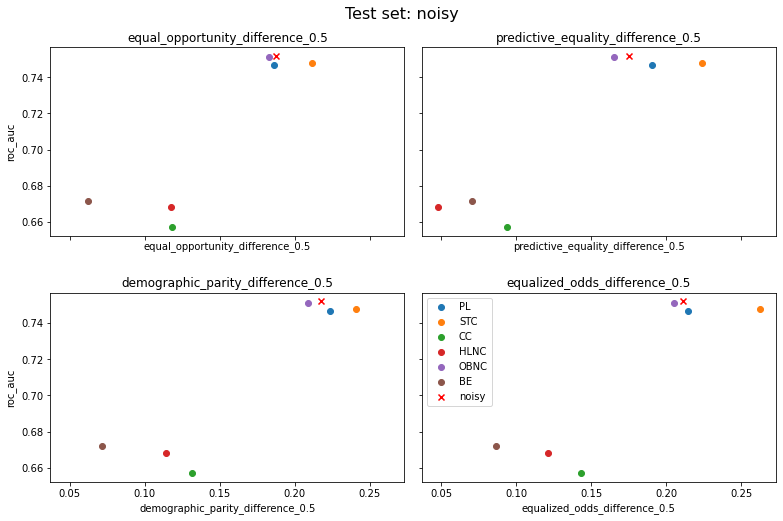

In [10]:
plot_trade_offs('noisy', 'roc_auc', base_algorithms)

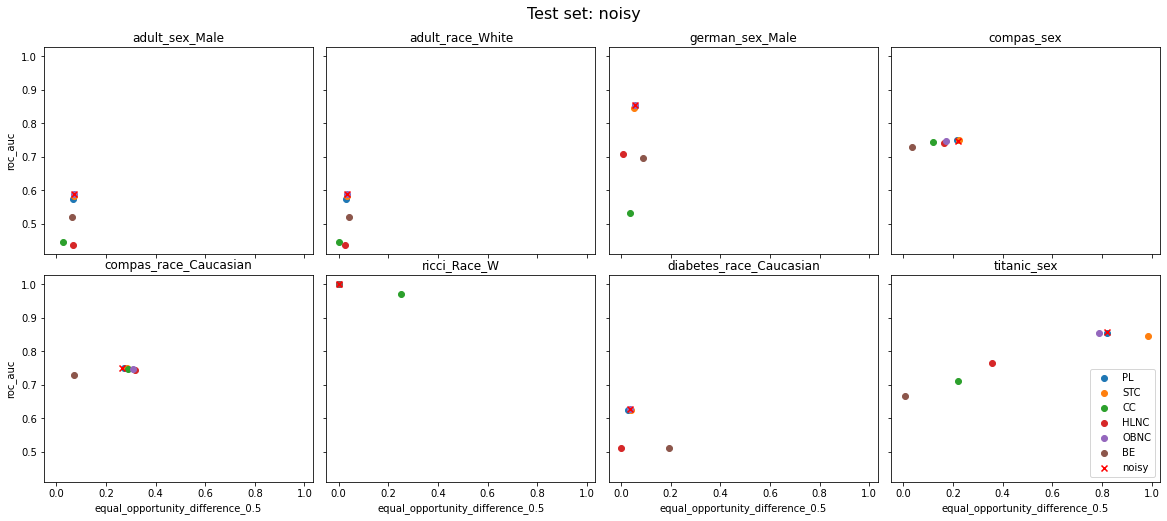

In [11]:
trade_off_experiment('noisy', 'equal_opportunity_difference_0.5', 'roc_auc', base_algorithms)

## Corrected test set

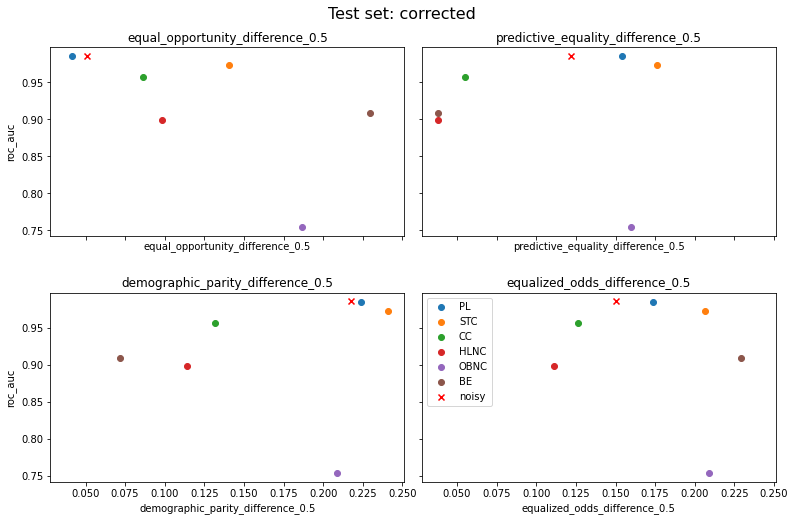

In [12]:
plot_trade_offs('corrected', 'roc_auc', base_algorithms)

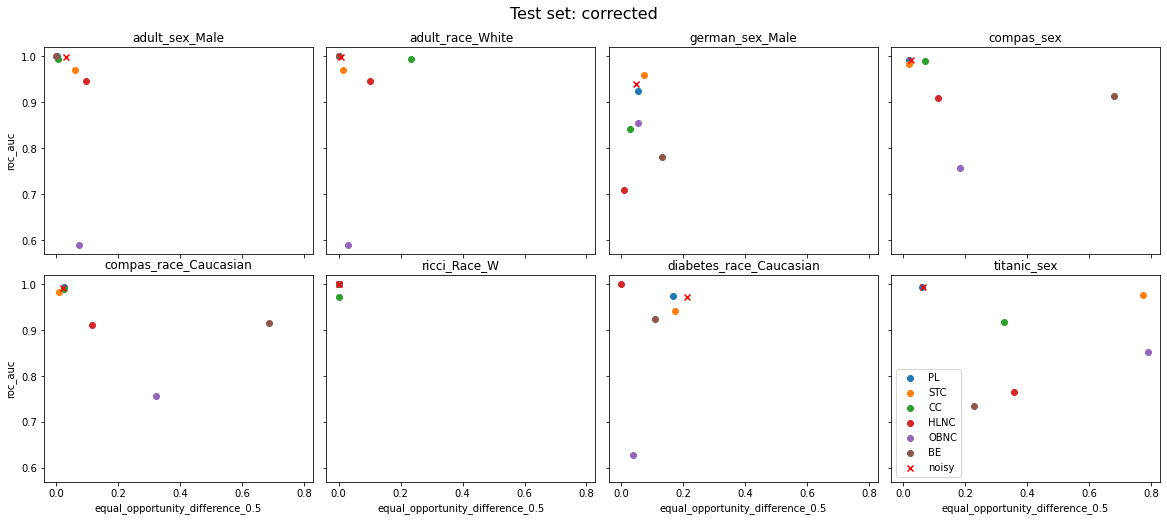

In [13]:
trade_off_experiment('corrected', 'equal_opportunity_difference_0.5', 'roc_auc', base_algorithms)

# Fair OBNC

## Noisy test set

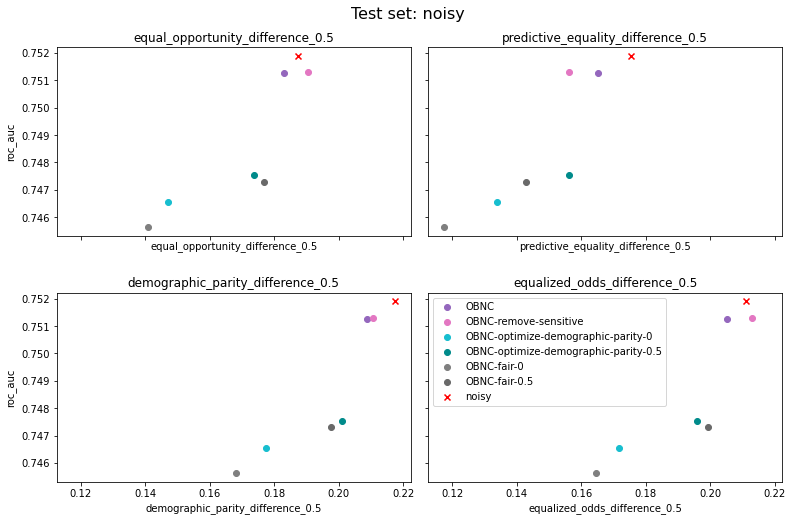

In [14]:
plot_trade_offs('noisy', 'roc_auc', OBNC_algorithms)

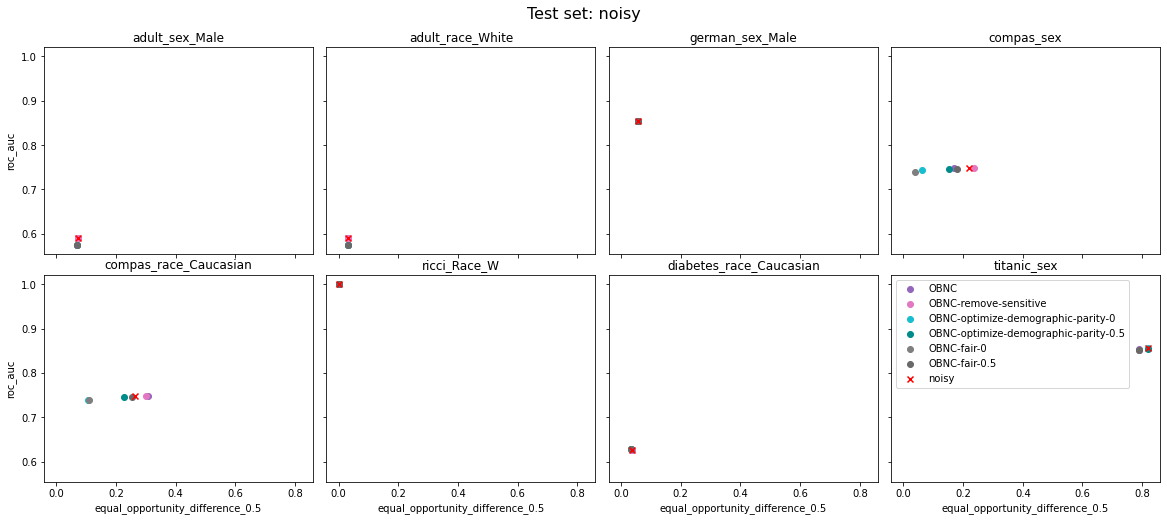

In [15]:
trade_off_experiment('noisy', 'equal_opportunity_difference_0.5', 'roc_auc', OBNC_algorithms)

## Corrected test set

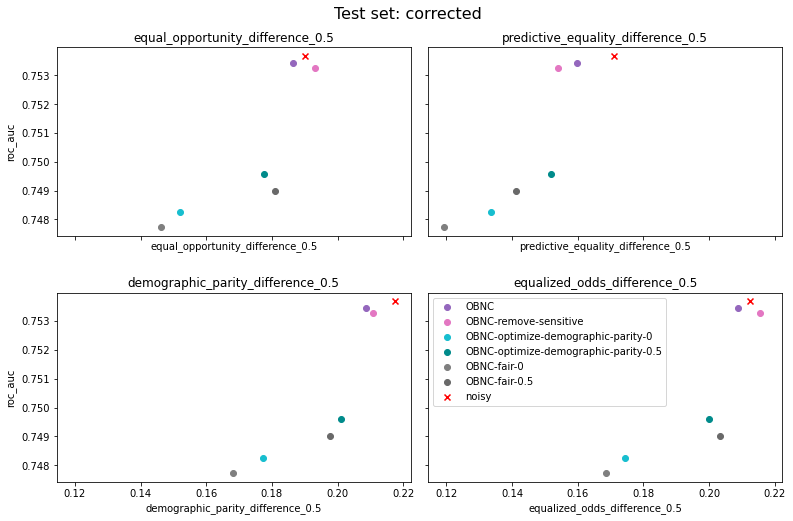

In [16]:
plot_trade_offs('corrected', 'roc_auc', OBNC_algorithms)

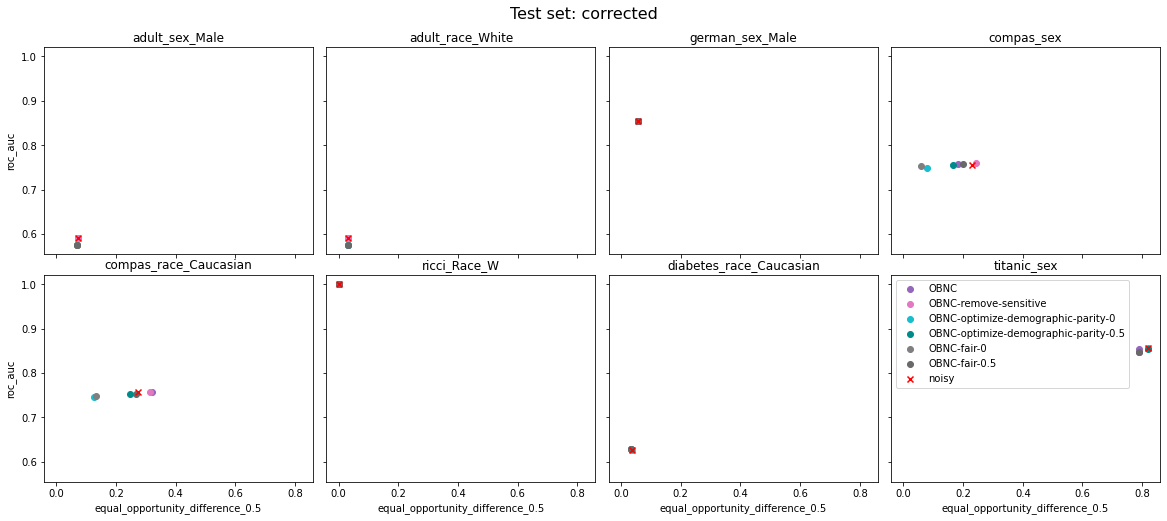

In [17]:
trade_off_experiment('corrected', 'equal_opportunity_difference_0.5', 'roc_auc', OBNC_algorithms)